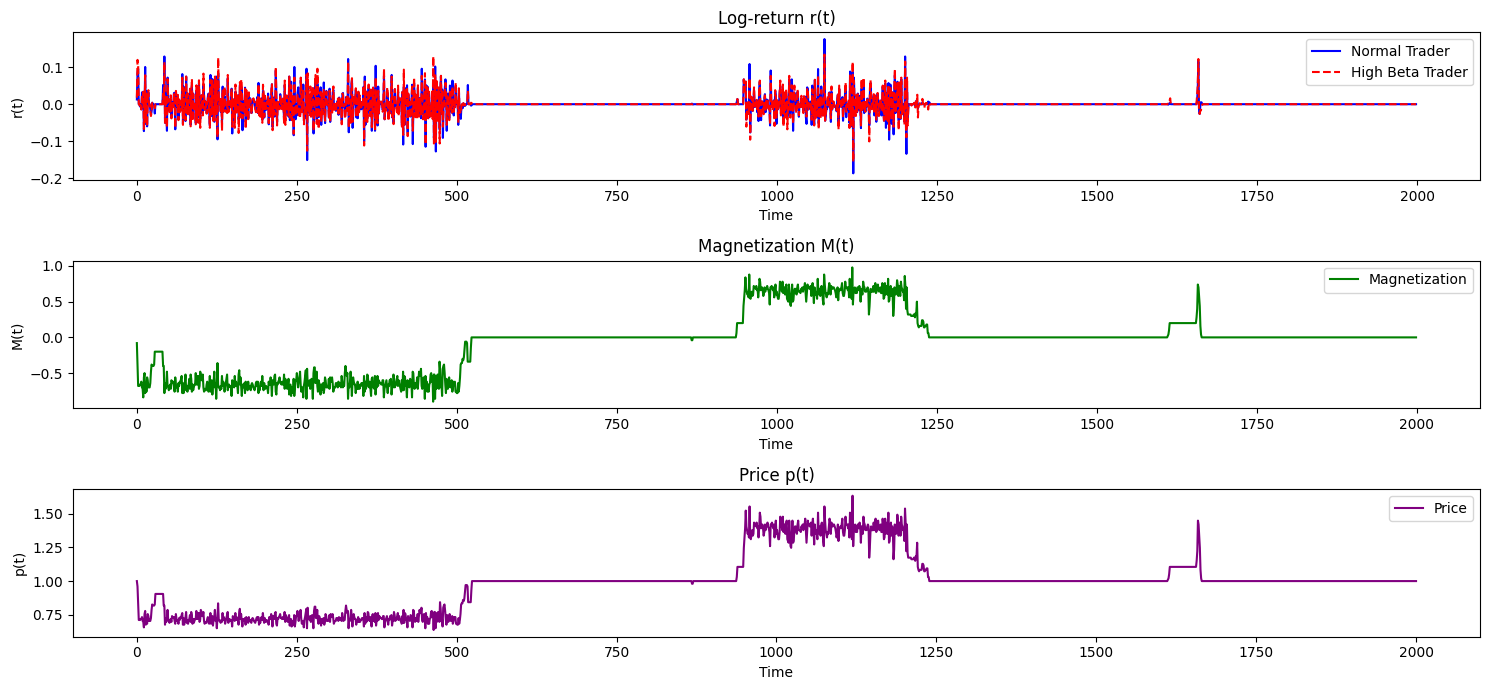

Normal Trader Stats:
Average Log-return: 0.00034617308654327176
Average Price: 0.9858053224083789

High Beta Trader Stats:
Average Log-return: 0.000448624312156078
Average Price: 0.9858053224083789


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Constants and Parameters
M, N = 10, 10
T = 0.5
BETA = 1 / T
HIGH_BETA = 1e5
J = 1
ALPHA = 2.8
P_STAR = 1
a = 1
m = 100
b = 1
n = M * N
class Trader:
    def __init__(self, beta):
        self.s = 1 if np.random.rand() < 0.5 else -1
        self.beta = beta
    def update_spin(self, h):
        bh = self.beta * h
        if bh > 100:
            p = 1
        elif bh < -100:
            p = 0
        else:
            p = 1 / (1 + np.exp(-2 * bh))
        self.s = 1 if np.random.rand() < p else -1
    
class HighBetaTrader(Trader):
    def __init__(self):
        super().__init__(HIGH_BETA)

class NormalTrader(Trader):
    def __init__(self):
        super().__init__(BETA)

def initialize_lattice():
    traders = [NormalTrader() for _ in range(n // 2)] + [HighBetaTrader() for _ in range(n // 2)]
    np.random.shuffle(traders)
    return [traders[i*N:i*N+N] for i in range(M)]

    # def initialize_lattice():
    #     half = N // 2 # half the lattice width
    #     left_traders = [NormalTrader() for _ in range(n // 2)]
    #     right_traders = [HighBetaTrader() for _ in range(n // 2)]
    #     trader_lattice = []

    #     for _ in range(M):
    #         row = left_traders[:half] + right_traders[:half]
    #         trader_lattice.append(row)
    #         left_traders = left_traders[half:]
    #         right_traders = right_traders[half:]
    #         return trader_lattice
def compute_local_field(trader_lattice, i, j):
    h = 0
    M_t = np.mean([t.s for row in trader_lattice for t in row])
    for x, y in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
        x = x % M
        y = y % N
        h += J * trader_lattice[x][y].s
    h -= ALPHA * trader_lattice[i][j].s * abs(M_t)
    return h

def fundamentalist_demand(p_t):
    return a * m * (np.log(P_STAR) - np.log(p_t))

def simulate(steps=2000):
    trader_lattice = initialize_lattice()
    magnetizations = []
    prices = [P_STAR]
    trader_log_returns, high_beta_log_returns = [], []
    for step in range(steps):
    # Initialize current returns for the time step
        current_trader_returns, current_high_beta_returns = [], []
        for i in range(M):
            for j in range(N):
                old_spin = trader_lattice[i][j].s
                h = compute_local_field(trader_lattice, i, j)
                trader_lattice[i][j].update_spin(h)
        # Calculate the market return after all traders potentially change spin
        if step > 0: # Ensure there is a previous price to compare
            r_t = np.log(prices[-1]) - np.log(prices[-2])

            # Now, we iterate over all traders to calculate their individual returns
            for i in range(M):
                for j in range(N):
                    if isinstance(trader_lattice[i][j], NormalTrader):
                        current_trader_returns.append(r_t if trader_lattice[i][j].s == 1 else -r_t)
                    elif isinstance(trader_lattice[i][j], HighBetaTrader):
                        current_high_beta_returns.append(r_t if trader_lattice[i][j].s == 1 else -r_t)
        M_t = np.mean([t.s for row in trader_lattice for t in row])
        magnetizations.append(M_t)
        xF = fundamentalist_demand(prices[-1])
        xI = b * 0.5 * n * M_t
        new_price = prices[-1] * np.exp((xF + xI) / (a * m))
        prices.append(new_price)
        # Record average return for each type of trader during this time step
        if step > 0: # No returns to record for the first step since there is no previous price
            trader_log_returns.append(np.mean(current_trader_returns))
            high_beta_log_returns.append(np.mean(current_high_beta_returns))
    return trader_log_returns, magnetizations, prices, high_beta_log_returns


trader_log_returns, magnetizations, prices, high_beta_log_returns = simulate()
plt.figure(figsize=(15, 7))
# Log Returns
plt.subplot(3, 1, 1)
plt.plot(trader_log_returns, label="Normal Trader", color="blue")
plt.plot(high_beta_log_returns, label="High Beta Trader", color="red", linestyle="--")
plt.title("Log-return r(t)")
plt.xlabel("Time")
plt.ylabel("r(t)")
plt.legend()
# Magnetization
plt.subplot(3, 1, 2)
plt.plot(magnetizations, label="Magnetization", color="green")
plt.title("Magnetization M(t)")
plt.xlabel("Time")
plt.ylabel("M(t)")
plt.legend()
# Price
plt.subplot(3, 1, 3)
plt.plot(prices, label="Price", color="purple")
plt.title("Price p(t)")
plt.xlabel("Time")
plt.ylabel("p(t)")
plt.legend()
plt.tight_layout()
plt.show()
# Statistics
print("Normal Trader Stats:")
print(f"Average Log-return: {np.mean(trader_log_returns)}")
print(f"Average Price: {np.mean(prices)}")
print("\nHigh Beta Trader Stats:")
print(f"Average Log-return: {np.mean(high_beta_log_returns)}")
print(f"Average Price: {np.mean(prices)}")